In [1]:
import numpy as np
from scipy.interpolate import CubicSpline

method = '6'
# mol fraction
# L lineal
# alpha Lineal
# beta Inverso

# Plot configurations

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.colors as mcolors


matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'arial'
matplotlib.rcParams['mathtext.it'] = 'arial'
matplotlib.rcParams['mathtext.bf'] = 'arial'
matplotlib.rcParams['xtick.major.pad']='5'
matplotlib.rcParams['ytick.major.pad']='5'
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['savefig.dpi'] = 1200

font = {'weight' : 'normal',
        'size'   : 16,
        'family' : "arial"}
plt.rc('font', **font)
plt.rc('axes', titlesize=font["size"])

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

# ePC-SAFT model

In [3]:
from epcsaftpy import component, pcsaft
import json

with open('parameters/viscosity_parameters_FVT_solvents.json') as json_file:
        parameters_solvent = json.load(json_file)


def saft_definition(solvent_name, cation_name, anion_name):
    viscosity_parameters = parameters_solvent[solvent_name]
    n_parameters = len(viscosity_parameters)

    solvent = component(solvent_name, pure_path = 'parameters/solvents.json',
                        viscosity_parameters = viscosity_parameters)
    cation = component(cation_name, pure_path = 'parameters/ions.json',                        
                       viscosity_parameters = np.zeros(n_parameters))   # Just to generate the space with the same dimension
    anion = component(anion_name, pure_path = 'parameters/ions.json',
                      viscosity_parameters = np.zeros(n_parameters))    # Just to generate the space with the same dimension

    mix = solvent + cation + anion
    # Define binary interaction parameters
    kijs = json.load(open('parameters/kijs.json'))
    for i in range(mix.nc):
        for j in range(mix.nc):
            key = mix.names[i] + "_" + mix.names[j]
            try:
                kij = kijs[key]
                if type(kij)==list:
                    mix.set_kijsaft(i, j, kij0=kij[0], kij1=kij[1])
                else:
                    mix.set_kijsaft(i, j, kij0=kij)
            except:
                pass
    return pcsaft(mix)



# FVT model

In [4]:
# Constants
kb = 1.3806488e-23  # [J/K] Boltzman's constant
Na = 6.022142e23  # [mol-1] Avogadro's Number
R = Na * kb    # [J mol-1 K-1] Ideal gas constant

A22, B22, C22, D22, E22, = 1.16145, 0.14874, 0.52487, 0.7732, 2.16178 
F22, R22, S22, W22, P22  = 2.43787, -6.435e-4, 18.0323, -0.7683, 7.27371

def viscosity_mix(x, rho, T, saft, viscosity_parameters_salt):
    """
    viscosity for mixtures using free volume theory

    Parameters
    ----------
    x: array_like
        molar fraction array
    rho : float
        molar density [mol/m3]
    T : float
        temperature [K]
    eos : object
        an EoS
    Xass0: array, optional
        Initial guess for the calculation of fraction of non-bonded sites

    Returns
    -------
    ten : float
        viscosity [mPa * s]
    """

    # Chapman-Enskog viscosity calculation
    Tad = T/(saft.eps / kb)
    Omega22 = A22/Tad**B22 + C22/np.exp(D22 * Tad) + E22 / np.exp(F22 * Tad)
    Omega22 += R22 * Tad**B22 * np.sin(S22 * Tad**W22 - P22)

    visc_ref = np.sqrt(saft.Mw * T * kb / (1000 * Na * np.pi))
    visc_ref *= 5/16
    visc_ref /= saft.sigma**2 * Omega22

    # Free volume theory for dense contributions
    Lvi, alphai, Bi = saft.viscosity_parameters.T
    Lv_salt, alpha_salt, B_salt = viscosity_parameters_salt

    if saft.nc == 3:
        Lv_solv, alpha_solv, B_solv = [Lvi[0], alphai[0], Bi[0]]
        Lvi = np.array([Lv_solv, Lv_salt])
        alphai = np.array([alpha_solv, alpha_salt])
        Bi = np.array([B_solv, B_salt])
    elif saft.nc == 4:
        Lvw, alphaw, Bw = [Lvi[0], alphai[0], Bi[0]]
        Lvc, alphac, Bc = [Lvi[1], alphai[1], Bi[1]]

        Lvi = np.array([Lvw, Lvc, Lv_salt])
        alphai = np.array([alphaw, alphac, alpha_salt])
        Bi = np.array([Bw, Bc, B_salt])



    # Molar fractions to mass fractions 
    if saft.nc == 3:
        xw_ = x[0]
        xs_ = x[1] 
        x_ = np.array([xw_, xs_])
        x_ /= np.sum(x_)
    elif saft.nc == 4:
        xw_ = x[0]
        xc_ = x[1]
        xs_ = x[2]
        x_ = np.array([xw_, xc_, xs_])
        x_ /= np.sum(x_)



    # Mixing rules
    Lv = np.dot(Lvi, x_)
    Lv *= 1e-10
    alpha = np.dot(alphai, x_)
    B = 1/np.dot(1/Bi, x_)

    P = saft.pressure(x, rho, T)
    RT = R *  T
    Mw = np.dot(saft.Mw, x)

    visc = (P + 1e-3 * alpha * rho**2 * Mw) * Lv 
    visc *= np.sqrt(1e-3 * Mw/(3*R*T))
    visc *= np.exp(B*((P + 1e-3 * alpha * rho**2 * Mw) / (rho * RT))**1.5)
    return (visc + visc_ref[0]) * 1e3

def viscosity_pure(rho, T, saft, Xass0 = None):
    """
    viscosity for pure components using free volume theory

    Parameters
    ----------
    rho : float
        molar density [mol/m3]
    T : float
        temperature [K]
    eos : object
        an EoS
    Xass0: array, optional
        Initial guess for the calculation of fraction of non-bonded sites

    Returns
    -------
    ten : float
        viscosity [mPa * s]
    """
    Tad = T/(saft.eps / kb)
    Omega22 = A22/Tad**B22 + C22/np.exp(D22 * Tad) + E22 / np.exp(F22 * Tad)
    Omega22 += R22 * Tad**B22 * np.sin(S22 * Tad**W22 - P22)

    visc_ref = np.sqrt(saft.Mw * T * kb / (1000 * Na * np.pi))
    visc_ref *= 5/16
    visc_ref /= saft.sigma**2 * Omega22


    Lv, alpha, B = saft.viscosity_parameters
    Lv *= 1e-10

    if isinstance(T, (int, np.int32, np.int64)):
        T = T * 1.0
        
    P = saft.pressure(rho, T)
    RT = R *  T

    visc = (P + 1e-3 * alpha * rho**2 * saft.Mw) * Lv 
    visc *= np.sqrt(1e-3 * saft.Mw/(3*R*T))
    visc *= np.exp(B*((P + 1e-3 * alpha * rho**2 * saft.Mw) / (rho * RT))**1.5)
    return (visc + visc_ref) * 1e3

# Objetive function

In [5]:
P = 1.01325e5 # Pa

def fobj_fit(inc, saft, rho_cal, x_exp, T_exp, m_exp, visc_exp):
    viscosity_parameters_salt = inc**2
    n_exp = len(T_exp)
    fo = np.ones_like(visc_exp)
    for i in range(n_exp):            
        visc_cal = viscosity_mix(x_exp[i], rho_cal[i], T_exp[i], saft, viscosity_parameters_salt)
        fo[i] = (visc_cal - visc_exp[i])/visc_exp[i]
    return fo

## ePC-SAFT calculation

In [6]:
solvent_name = 'water'
cation_list = ['Na+', 'K+', 'Li+']
anion_list = ['Br-', 'Cl-', 'F-', 'I-']

n_cations = len(cation_list)
n_anions = len(anion_list)

Tmin = 280 # K
Tmax = 360 # K
P = 1.01325e5

saft_calculations = {}

for i, cation_name in enumerate(cation_list):
    for j, anion_name in enumerate(anion_list):
        path_exp = '../data_exp/viscosity_' + solvent_name + '_' + cation_name + anion_name + '.txt'
        saft = saft_definition(solvent_name, cation_name, anion_name)
        try:
            T_exp, m_exp, visc_exp = np.loadtxt(path_exp, unpack=True)
            visc_exp /= 1000 
            index = np.where((T_exp>=Tmin) & (T_exp<=Tmax))
            T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
            n_exp = len(T_exp)
            rho = np.zeros(n_exp)
            x = np.zeros((n_exp, 3))
            for i in range(n_exp):            
                x[i] = np.array([1e3/saft.Mw_solv[0], m_exp[i], m_exp[i]])
                x[i] /= np.sum(x[i])
                rho[i] = saft.density(x[i], T_exp[i], P, 'L')
            calculation = True
        except:
            calculation = False
            continue
        if calculation:
            # save the results
            saft_calculations[cation_name + anion_name] = {'Texp': T_exp, 'mexp': m_exp, 'viscexp': visc_exp, 'rho': rho, 'x': x, 'saft': saft}
       

# Optimization

In [7]:
from scipy.optimize import least_squares

print("|     name    |        Lv [A]        |alph [J m3 mol-1 kg-1]|            B         |  Success   |   nfev     |     F(x)   |")
print("|-------------|----------------------|----------------------|----------------------|------------|------------|------------|")

viscosity_parameters = {}
for i, cation_name in enumerate(cation_list):
    for j, anion_name in enumerate(anion_list):
        try:
            T_exp = saft_calculations[cation_name + anion_name]['Texp']
            m_exp = saft_calculations[cation_name + anion_name]['mexp']
            visc_exp = saft_calculations[cation_name + anion_name]['viscexp']
            rho = saft_calculations[cation_name + anion_name]['rho']
            x = saft_calculations[cation_name + anion_name]['x']
            saft = saft_calculations[cation_name + anion_name]['saft']
            n_exp = len(T_exp)
            fit = True
        except:
            fit = False
            continue
        if fit:
            inc0 = np.array(parameters_solvent['water'])**0.5
            res = least_squares(fobj_fit, inc0, args=(saft, rho, x, T_exp, m_exp, visc_exp), method='lm', max_nfev=5000)
            Lvi, alphai, Bi = res.x**2
            viscosity_parameters[cation_name + anion_name] = [Lvi, alphai, Bi]
            print(f"|  {cation_name[0:-1] + anion_name[0:-1]:<10} | {Lvi:>20.5f} | {alphai:>20.5f} | {Bi:>20.5f} |  {res.success:<9} |  {res.nfev:<9} |  {res.cost:>9.4f} |")
print("|-------------|----------------------|----------------------|----------------------|------------|------------|------------|")
# Save parameters
with open('parameters/viscosity_parameters_FVT_salts_method_' + method + '.json', 'w') as fp:
    json.dump(viscosity_parameters, fp, indent=4)


|     name    |        Lv [A]        |alph [J m3 mol-1 kg-1]|            B         |  Success   |   nfev     |     F(x)   |
|-------------|----------------------|----------------------|----------------------|------------|------------|------------|


/var/folders/2x/7c4jk1yj5vschq7hbp922pyc0000gn/T/ipykernel_36521/2293693591.py:87: RuntimeWarning: overflow encountered in exp
  visc *= np.exp(B*((P + 1e-3 * alpha * rho**2 * Mw) / (rho * RT))**1.5)


KeyboardInterrupt: 

# ePC-SAFT calculation in water

In [8]:
data_cal = {}
data_exp = {}
solvent_name = 'water'

n = 100

with open('parameters/viscosity_parameters_FVT_salts_method_' + method + '.json') as json_file:
        parameters_salts = json.load(json_file)

for i, cation in enumerate(cation_list):
    for j, anion in enumerate(anion_list):
        path_exp = '../data_exp/viscosity_' + solvent_name + '_' + cation + anion + '.txt'
        saft = saft_definition(solvent_name, cation, anion)
        viscosity_parameters_salt = parameters_salts[cation + anion]
        try:
            T_exp, m_exp, visc_exp = np.loadtxt(path_exp, unpack=True)
            visc_exp /= 1000 
            index = np.where((T_exp>=Tmin) & (T_exp<=Tmax))
            T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
            T_list = np.unique(T_exp)
            m_max = round(max(m_exp) + 0.5, 0)
            calculation = True
        except:
            calculation = False
            continue
        if calculation:
            m = np.linspace(0, m_max, n)
            n_T = len(T_list)
            visc = np.zeros((n_T, n))
            for k, T in enumerate(T_list):
                for l in range(n):
                    x = np.array([1e3/saft.Mw_solv[0], m[l], m[l]])
                    x /= np.sum(x)
                    rho = saft.density(x, T, P, 'L')
                    visc[k, l] = viscosity_mix(x, rho, T, saft, viscosity_parameters_salt)

            data_cal[cation + anion] = {'T': T_list, 'm': m, 'visc': visc}
            data_exp[cation + anion] = {'T': T_exp, 'm': m_exp, 'visc': visc_exp}

# Plot

In [9]:
color1 = '#448AFF'
color2 = "#F44336"

fig, axs = plt.subplots(n_cations, n_anions, figsize=(3.93701 * n_anions, 3.1496 * n_cations), dpi=1200)
fig.subplots_adjust(hspace=.5, wspace=0.5)

Tmin = 280 # K
Tmax = 360 # K

n = Tmax - Tmin + 1
colors = get_color_gradient(color1, color2, n)



for i, cation in enumerate(cation_list):
    for j, anion in enumerate(anion_list):
        ax = axs[i, j]
        # delete the last elements of a list
        ax.set_title(cation[0:-1] + anion[0:-1])

        T_list, m, visc = data_cal[cation + anion]['T'], data_cal[cation + anion]['m'], data_cal[cation + anion]['visc']
        T_exp, m_exp, visc_exp = data_exp[cation + anion]['T'], data_exp[cation + anion]['m'], data_exp[cation + anion]['visc']
        n_T = len(T_list)

        if cation[0:-1] + anion[0:-1] != 'LiF':


            T0 = 100
            for k in range(n_T):
                index = T_exp == T_list[k]
                T1 = T_list[k]
                dT = T1 - T0
                if dT > 2:
                    color = colors[int(T1 - Tmin)]
                    ax.scatter(m_exp[index], visc_exp[index], color = color, marker = 'o', linewidth=0.5, edgecolor='k', s = 25)
                    ax.plot(m, visc[k], color = color, linewidth = 1.5)
                    T0 = T1

        start, end = ax.get_ylim()
        ax.set_ylim([round(start - 0.05, 1), round(end + 0.05, 1)])
        ax.set_xlim([0, max(m)])
        ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
        ax.set_ylabel(r'$\eta$ / cp')

plt.show()



In [10]:
# For Latex
l = -1
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

for i, anion in enumerate(anion_list):
    for j, cation in enumerate(cation_list):
        l += 1
        letter = letters[l]

        cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)
        data = np.random.rand(10, 10)
        fig, ax = plt.subplots()
        im = ax.imshow(data, cmap=cmap, vmin=Tmin, vmax=Tmax)
        cb = plt.colorbar(im, ax=ax)
        cb.ax.tick_params(colors='black', labelsize=12)
        plt.close()

        fig, ax = plt.subplots( figsize=(3.93701 + 0.5, 3.1496), dpi=1200)
        ax.text(0.06, 0.92, letter, horizontalalignment='center', verticalalignment='center', 
                        transform=ax.transAxes, fontsize = 16) 
        ax.set_title(cation[0:-1] + anion[0:-1])

        T_list, m, visc = data_cal[cation + anion]['T'], data_cal[cation + anion]['m'], data_cal[cation + anion]['visc']
        T_exp, m_exp, visc_exp = data_exp[cation + anion]['T'], data_exp[cation + anion]['m'], data_exp[cation + anion]['visc']
        n_T = len(T_list)

        if cation[0:-1] + anion[0:-1] != 'LiF':
            T0 = 100
            for k in range(n_T):
                index = T_exp == T_list[k]
                T1 = T_list[k]
                dT = T1 - T0
                if dT > 5:
                    color = colors[int(T1 - Tmin)]
                    ax.scatter(m_exp[index], visc_exp[index], color = color, marker = 'o', linewidth=0.5, edgecolor='k', s = 40)
                    ax.plot(m, visc[k], color = color, linewidth = 1.5)
                    T0 = T1


        ax.set_xlim([0, max(m)])
        start, end = ax.get_ylim()
        ax.set_ylim([round(start - 0.05, 1), round(end + 0.05, 1)])
        
        
        ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
        ax.set_ylabel(r'$\eta$ / cp')
        cb = plt.colorbar(im, ax=ax)
        cb.ax.tick_params(colors='black', labelsize=16)
        cb.set_label(r'$T$ / K', fontsize=16)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.savefig('../figures/03' + letter + '_viscosity_' + cation[0:-1] + anion[0:-1] + '_FVT_method_' + method + '.pdf')
        plt.close()


# AAD table

In [11]:
solvent_name = 'water'
cation_list = ['Na+', 'K+', 'Li+']
anion_list = ['Br-', 'Cl-', 'F-', 'I-']

n_cations = len(cation_list)
n_anions = len(anion_list)


n = 25
Tmin = 280 # K
Tmax = 360 # K
P = 1.01325e5

def print_AAD(solvent_name):
    print(f"\n Solvent: {solvent_name}")
    print("|    name         | range m [mol/kg]|  range T [K]    |       Np        |  AAD % visc     |")
    print("|-----------------|-----------------|-----------------|-----------------|-----------------|")
    for i, cation in enumerate(cation_list):
        for j, anion in enumerate(anion_list):
            path_exp = '../data_exp/viscosity_' + solvent_name + '_' + cation + anion + '.txt'
            saft = saft_definition(solvent_name, cation, anion)
            viscosity_parameters_salt = parameters_salts[cation + anion]
            
            try:
                if solvent_name == 'water':
                    T_exp, m_exp, visc_exp = np.loadtxt(path_exp, unpack=True)
                else:
                    T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)
                    index = np.where(c_exp == 1)
                    T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
                visc_exp /= 1000 
                index = np.where((T_exp>=Tmin) & (T_exp<=Tmax))
                T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
                calculation = True
                if len(T_exp) == 0:
                    calculation = False
            except:
                calculation = False
                continue
            AAD = 0
            n = len(T_exp)
            if calculation:
                for l in range(n):
                    x = np.array([1e3/saft.Mw_solv[0], m_exp[l], m_exp[l]])
                    x /= np.sum(x)
                    rho = saft.density(x, T_exp[l], P, 'L') 
                    visc_cal = viscosity_mix(x, rho, T_exp[l], saft, viscosity_parameters_salt)
                    AAD += abs(visc_cal - visc_exp[l]) / visc_exp[l]
                AAD /= n
                print(f"|{cation[0:-1] + anion[0:-1]:^17}|{min(m_exp):^8.2f}-{max(m_exp):^8.2f}|{min(T_exp):^8.2f}-{max(T_exp):^8.2f}|{n:^17}|{AAD*100:^17.2f}|")
            
    print("|-----------------|-----------------|-----------------|-----------------|-----------------|")


print_AAD('water')
print_AAD('methanol')
print_AAD('ethanol')


    


 Solvent: water
|    name         | range m [mol/kg]|  range T [K]    |       Np        |  AAD % visc     |
|-----------------|-----------------|-----------------|-----------------|-----------------|
|      NaBr       |  0.46  -  9.00  | 288.00 - 348.00 |       71        |      1.81       |
|      NaCl       |  0.50  -  5.40  | 291.15 - 358.15 |       38        |      1.38       |
|       NaF       |  0.00  -  0.96  | 288.00 - 328.00 |       52        |      2.05       |
|       NaI       |  0.17  -  4.70  | 302.00 - 353.00 |       18        |      1.61       |
|       KBr       |  0.50  -  4.00  | 293.15 - 333.15 |       30        |      1.73       |
|       KCl       |  0.50  -  4.00  | 293.15 - 333.15 |       30        |      0.95       |
|       KF        |  0.05  -  0.20  | 303.15 - 318.15 |       16        |      0.67       |
|       KI        |  0.50  -  4.00  | 293.15 - 333.15 |       30        |      1.89       |
|      LiBr       |  1.76  -  6.74  | 298.15 - 353.15 |       1

/var/folders/2x/7c4jk1yj5vschq7hbp922pyc0000gn/T/ipykernel_36521/3825057001.py:28: UserWarning: loadtxt: input contained no data: "../data_exp/viscosity_ethanol_K+Br-.txt"
  T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)


|       KI        |  0.00  -  0.08  | 288.15 - 298.15 |        9        |      30.94      |
|      LiBr       |  0.15  -  0.75  | 293.00 - 313.15 |       12        |      65.17      |
|      LiCl       |  0.20  -  3.91  | 283.15 - 323.15 |       30        |      73.29      |
|-----------------|-----------------|-----------------|-----------------|-----------------|


In [ ]:
T_list = [298.15]
combinations = ['Na+Cl-', 'Na+I-', 'K+Br-', 'K+Cl-', 'KI-', 'Li+Br-', 'Li+Cl-', 'Li+I-']
cations_in_combinations = ['Na+', 'Na+', 'K+', 'K+', 'K+', 'Li+', 'Li+', 'Li+']
anions_in_combinations = ['Cl-', 'I-', 'Br-', 'Cl-', 'I-', 'Br-', 'Cl-', 'I-']
colors = [
    "#3498db",  # Peter River
    "#e74c3c",  # Alizarin
    "#2ecc71",  # Emerald
    "#f1c40f",  # Sun Flower
    "#9b59b6",  # Amethyst
    "#34495e",  # Wet Asphalt
    "#e67e22",  # Carrot
    "#95a5a6",  # Concrete
]

n = 100

def calculation_plot(T_list, solvent_name, ax):
    for i, combination in enumerate(combinations):
        cation = cations_in_combinations[i]
        anion = anions_in_combinations[i]
        path_exp = '../data_exp/viscosity_' + solvent_name + '_' + cation + anion + '.txt'
        saft = saft_definition(solvent_name, cation, anion)
        viscosity_parameters_salt = parameters_salts[cation + anion]
        try:
            if solvent_name == 'water':
                T_exp, m_exp, visc_exp = np.loadtxt(path_exp, unpack=True)
            else:
                T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)
                index = np.where(c_exp == 1)
                T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
            visc_exp /= 1000
            index = np.where((T_exp>=Tmin) & (T_exp<=Tmax))
            T_exp, m_exp, visc_exp = T_exp[index], m_exp[index], visc_exp[index]
            n_exp = len(T_exp)
            T_exp_list = np.unique(T_exp)
            calculation = True
            if len(T_exp) == 0:
                calculation = False
            # if T_list is not in T_exp_list, then calculation = False
            for T in T_list:
                if T not in T_exp_list:
                    calculation = False
        except:
            calculation = False
            continue
        if calculation:
            for k, T in enumerate(T_list):
                index = T_exp == T
                color = colors[i]
                visc_cal = np.zeros(n)
                for j in range(n):
                    x = np.array([1e3/saft.Mw_solv[0], m[j], m[j]])
                    x /= np.sum(x)
                    rho = saft.density(x, T, P, 'L')
                    visc_cal[j] = viscosity_mix(x, rho, T, saft, viscosity_parameters_salt)
                ax.plot(m, visc_cal, color = color, linewidth = 1.5, linestyle = '-')
                ax.scatter(m_exp[index], visc_exp[index], color = color, marker = 'o', linewidth=0.5, edgecolor='k', s = 40, label = combination)



fig, axs = plt.subplots(2, 2, figsize=(3.93701 * 2, 3.1496 * 2), dpi=1200)
ax = axs[0, 0]
ax.text(0.06, 0.92, 'A', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
fig.subplots_adjust(hspace=.5, wspace=0.5)
ax.title.set_text('methanol at 298.15 K')
m = np.linspace(0, 2, n)
solvent_name = 'methanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([round(start - 0.05, 1), 2])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
ax.legend(fontsize=6)


ax = axs[0, 1]
ax.set_title('ethanol at 298.15 K')
ax.text(0.06, 0.92, 'B', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
m = np.linspace(0, .2, n)
solvent_name = 'ethanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([1, 1.4])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
ax.legend(fontsize=6)

    

T_list = [313.15]

ax = axs[1,0]
ax.set_title('methanol at 313.15 K')
ax.text(0.06, 0.92, 'C', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
m = np.linspace(0, 1, n)
solvent_name = 'methanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([round(start - 0.05, 1), 1])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
ax.legend(fontsize=6)




ax = axs[1,1]
ax.set_title('ethanol at 313.15 K')
ax.text(0.06, 0.92, 'D', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
m = np.linspace(0, 4, n)
solvent_name = 'ethanol'
calculation_plot(T_list, solvent_name, ax)
ax.set_ylim([0.5, 7.5])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
ax.legend(fontsize=6)
plt.show()

/var/folders/3j/0schr3dj5r16ky0vhld754bm0000gn/T/ipykernel_76311/4104299493.py:29: UserWarning: loadtxt: input contained no data: "../data_exp/viscosity_ethanol_K+Br-.txt"
  T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)


In [ ]:
T_list = [298.15]
combinations = ['Na+Cl-', 'Na+I-', 'K+Br-', 'K+Cl-', 'KI-', 'Li+Br-', 'Li+Cl-', 'Li+I-']
cations_in_combinations = ['Na+', 'Na+', 'K+', 'K+', 'K+', 'Li+', 'Li+', 'Li+']
anions_in_combinations = ['Cl-', 'I-', 'Br-', 'Cl-', 'I-', 'Br-', 'Cl-', 'I-']
colors = [
    "#3498db",  # Peter River
    "#e74c3c",  # Alizarin
    "#2ecc71",  # Emerald
    "#f1c40f",  # Sun Flower
    "#9b59b6",  # Amethyst
    "#34495e",  # Wet Asphalt
    "#e67e22",  # Carrot
    "#95a5a6",  # Concrete
]




fig, ax = plt.subplots( figsize=(3.93701, 3.1496), dpi=1200)
ax.text(0.06, 0.92, 'A', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
n = 100
m = np.linspace(0, 2, n)
solvent_name = 'methanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([round(start - 0.05, 1), 2])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('../figures/04A_viscosity_methanol_at_298K_FVT_method_' + method + '.pdf', dpi=1200)
plt.close()




fig, ax = plt.subplots( figsize=(3.93701, 3.1496), dpi=1200)
ax.text(0.06, 0.92, 'B', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
n = 100
m = np.linspace(0, .2, n)
solvent_name = 'ethanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([1, 1.4])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('../figures/04B_viscosity_ethanol_at_298K_FVT_method_' + method + '.pdf', dpi=1200)
plt.close()
    

T_list = [313.15]


fig, ax = plt.subplots( figsize=(3.93701, 3.1496), dpi=1200)
ax.text(0.06, 0.92, 'C', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
n = 100
m = np.linspace(0, 1, n)
solvent_name = 'methanol'
calculation_plot(T_list, solvent_name, ax)
start, end = ax.get_ylim()
ax.set_ylim([round(start - 0.05, 1), 1])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('../figures/04C_viscosity_methanol_at_313K_FVT_method_' + method + '.pdf', dpi=1200)
plt.close()




fig, ax = plt.subplots( figsize=(3.93701, 3.1496), dpi=1200)
ax.text(0.06, 0.92, 'D', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 
n = 100
m = np.linspace(0, 4, n)
solvent_name = 'ethanol'
calculation_plot(T_list, solvent_name, ax)
ax.set_ylim([0.5, 7.5])
ax.set_xlim([0, max(m)])
ax.set_xlabel(r'$m$ / mol $\cdot$ kg$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('../figures/04D_viscosity_ethanol_at_313K_FVT_method_' + method + '.pdf', dpi=1200)
plt.close()

/var/folders/3j/0schr3dj5r16ky0vhld754bm0000gn/T/ipykernel_76311/4104299493.py:29: UserWarning: loadtxt: input contained no data: "../data_exp/viscosity_ethanol_K+Br-.txt"
  T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)
/var/folders/3j/0schr3dj5r16ky0vhld754bm0000gn/T/ipykernel_76311/4104299493.py:29: UserWarning: loadtxt: input contained no data: "../data_exp/viscosity_ethanol_K+Br-.txt"
  T_exp, m_exp, visc_exp, c_exp = np.loadtxt(path_exp, unpack=True)


# Water mixtures (In preparation ...)

In [ ]:
def saft_definition_mix(solvent1_name, solvent2_name, cation_name, anion_name):
    n_parameters = len(parameters_solvent[solvent1_name])

    solvent1 = component(solvent1_name, pure_path = 'parameters/solvents.json',
                        viscosity_parameters = parameters_solvent[solvent1_name])
    solvent2 = component(solvent2_name, pure_path = 'parameters/solvents.json',
                        viscosity_parameters = parameters_solvent[solvent2_name])
    cation = component(cation_name, pure_path = 'parameters/ions.json',                        
                       viscosity_parameters = np.zeros(n_parameters))   # Just to generate the space with the same dimension
    anion = component(anion_name, pure_path = 'parameters/ions.json',
                      viscosity_parameters = np.zeros(n_parameters))    # Just to generate the space with the same dimension

    mix = solvent1 + solvent2 + cation + anion
    # Define binary interaction parameters
    kijs = json.load(open('parameters/kijs.json'))
    for i in range(mix.nc):
        for j in range(mix.nc):
            key = mix.names[i] + "_" + mix.names[j]
            try:
                kij = kijs[key]
                if type(kij)==list:
                    mix.set_kijsaft(i, j, kij0=kij[0], kij1=kij[1])
                else:
                    mix.set_kijsaft(i, j, kij0=kij)
            except:
                pass
    return pcsaft(mix)

In [ ]:
n = 50
w1 = np.linspace(0, 1, n) # water content w/w
def calculation_plot(solvent_name, cation, anion, ax):
    combination = cation + anion
    path_exp = '../data_exp/viscosity_' + solvent_name + '_' + cation + anion + '.txt'
    saft = saft_definition_mix('water', solvent_name, cation, anion)
    viscosity_parameters_salt = parameters_salts[cation + anion]
    try:
        T_exp, m_exp, visc_exp, w_exp = np.loadtxt(path_exp, unpack=True)
        visc_exp /= 1000
        index = np.where((T_exp>=Tmin) & (T_exp<=Tmax))
        T_exp, m_exp, visc_exp, w_exp = T_exp[index], m_exp[index], visc_exp[index], w_exp[index]
        n_exp = len(T_exp)
        T_list = np.unique(T_exp)
        # Select the temperature in T_list with more experimental points
        n_exp = 0
        for T in T_list:
            n = len(T_exp[T_exp == T])
            if n > n_exp:
                n_exp = n
                T_select = T
        index = T_exp == T_select
        m_exp, visc_exp, w_exp = m_exp[index], visc_exp[index], w_exp[index]
        n_exp = len(m_exp)
        m_list = np.unique(m_exp)
        if n_exp == 0:
            calculation = False
        else:
            # print T_select for the combinations with experimental data
            print(f"{combination}: {T_select}")
            calculation = True
    except:
        calculation = False
        pass

    if calculation:
        l = -1
        for k in range(0,len(m_list),4):
            l += 1
            m = m_list[k]
            index = m_exp == m
            n = len(w1)
            
            visc_cal = np.zeros(n)
            color = colors[l]
            
            for j in range(n):
                w2 = 1 - w1[j]
                # mass fraction to molar fraction (binary mixture)
                x_solv = np.array([w1[j] / saft.Mw_solv[0], w2 / saft.Mw_solv[1]])
                x_solv /= np.sum(x_solv)
                x = np.array([1e3/np.dot(x_solv, saft.Mw_solv), m, m])
                x /= np.sum(x)
                x = np.array([x_solv[0]*x[0], x_solv[1]*x[0], x[1], x[2]])
                rho = saft.density(x, T, P, 'L')
                visc_cal[j] = viscosity_mix(x, rho, T, saft, viscosity_parameters_salt)
            ax.plot(w1, visc_cal, color = color, linewidth = 1.5, linestyle = '-')
            ax.scatter(1 - w_exp[index], visc_exp[index], color = color, marker = 'o', linewidth=0.5, edgecolor='k', s = 40, label = f'{m:.2f} mol/kg')


Li+Cl-: 283.15


/Users/estebancea/anaconda3/envs/epcsaft/lib/python3.11/site-packages/epcsaftpy/pcsaft_mixtures/association/association_aux.py:126: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xass = fsolve(fobj_xass, x0=Xass, args=(xj, aux_asso, diagasso),


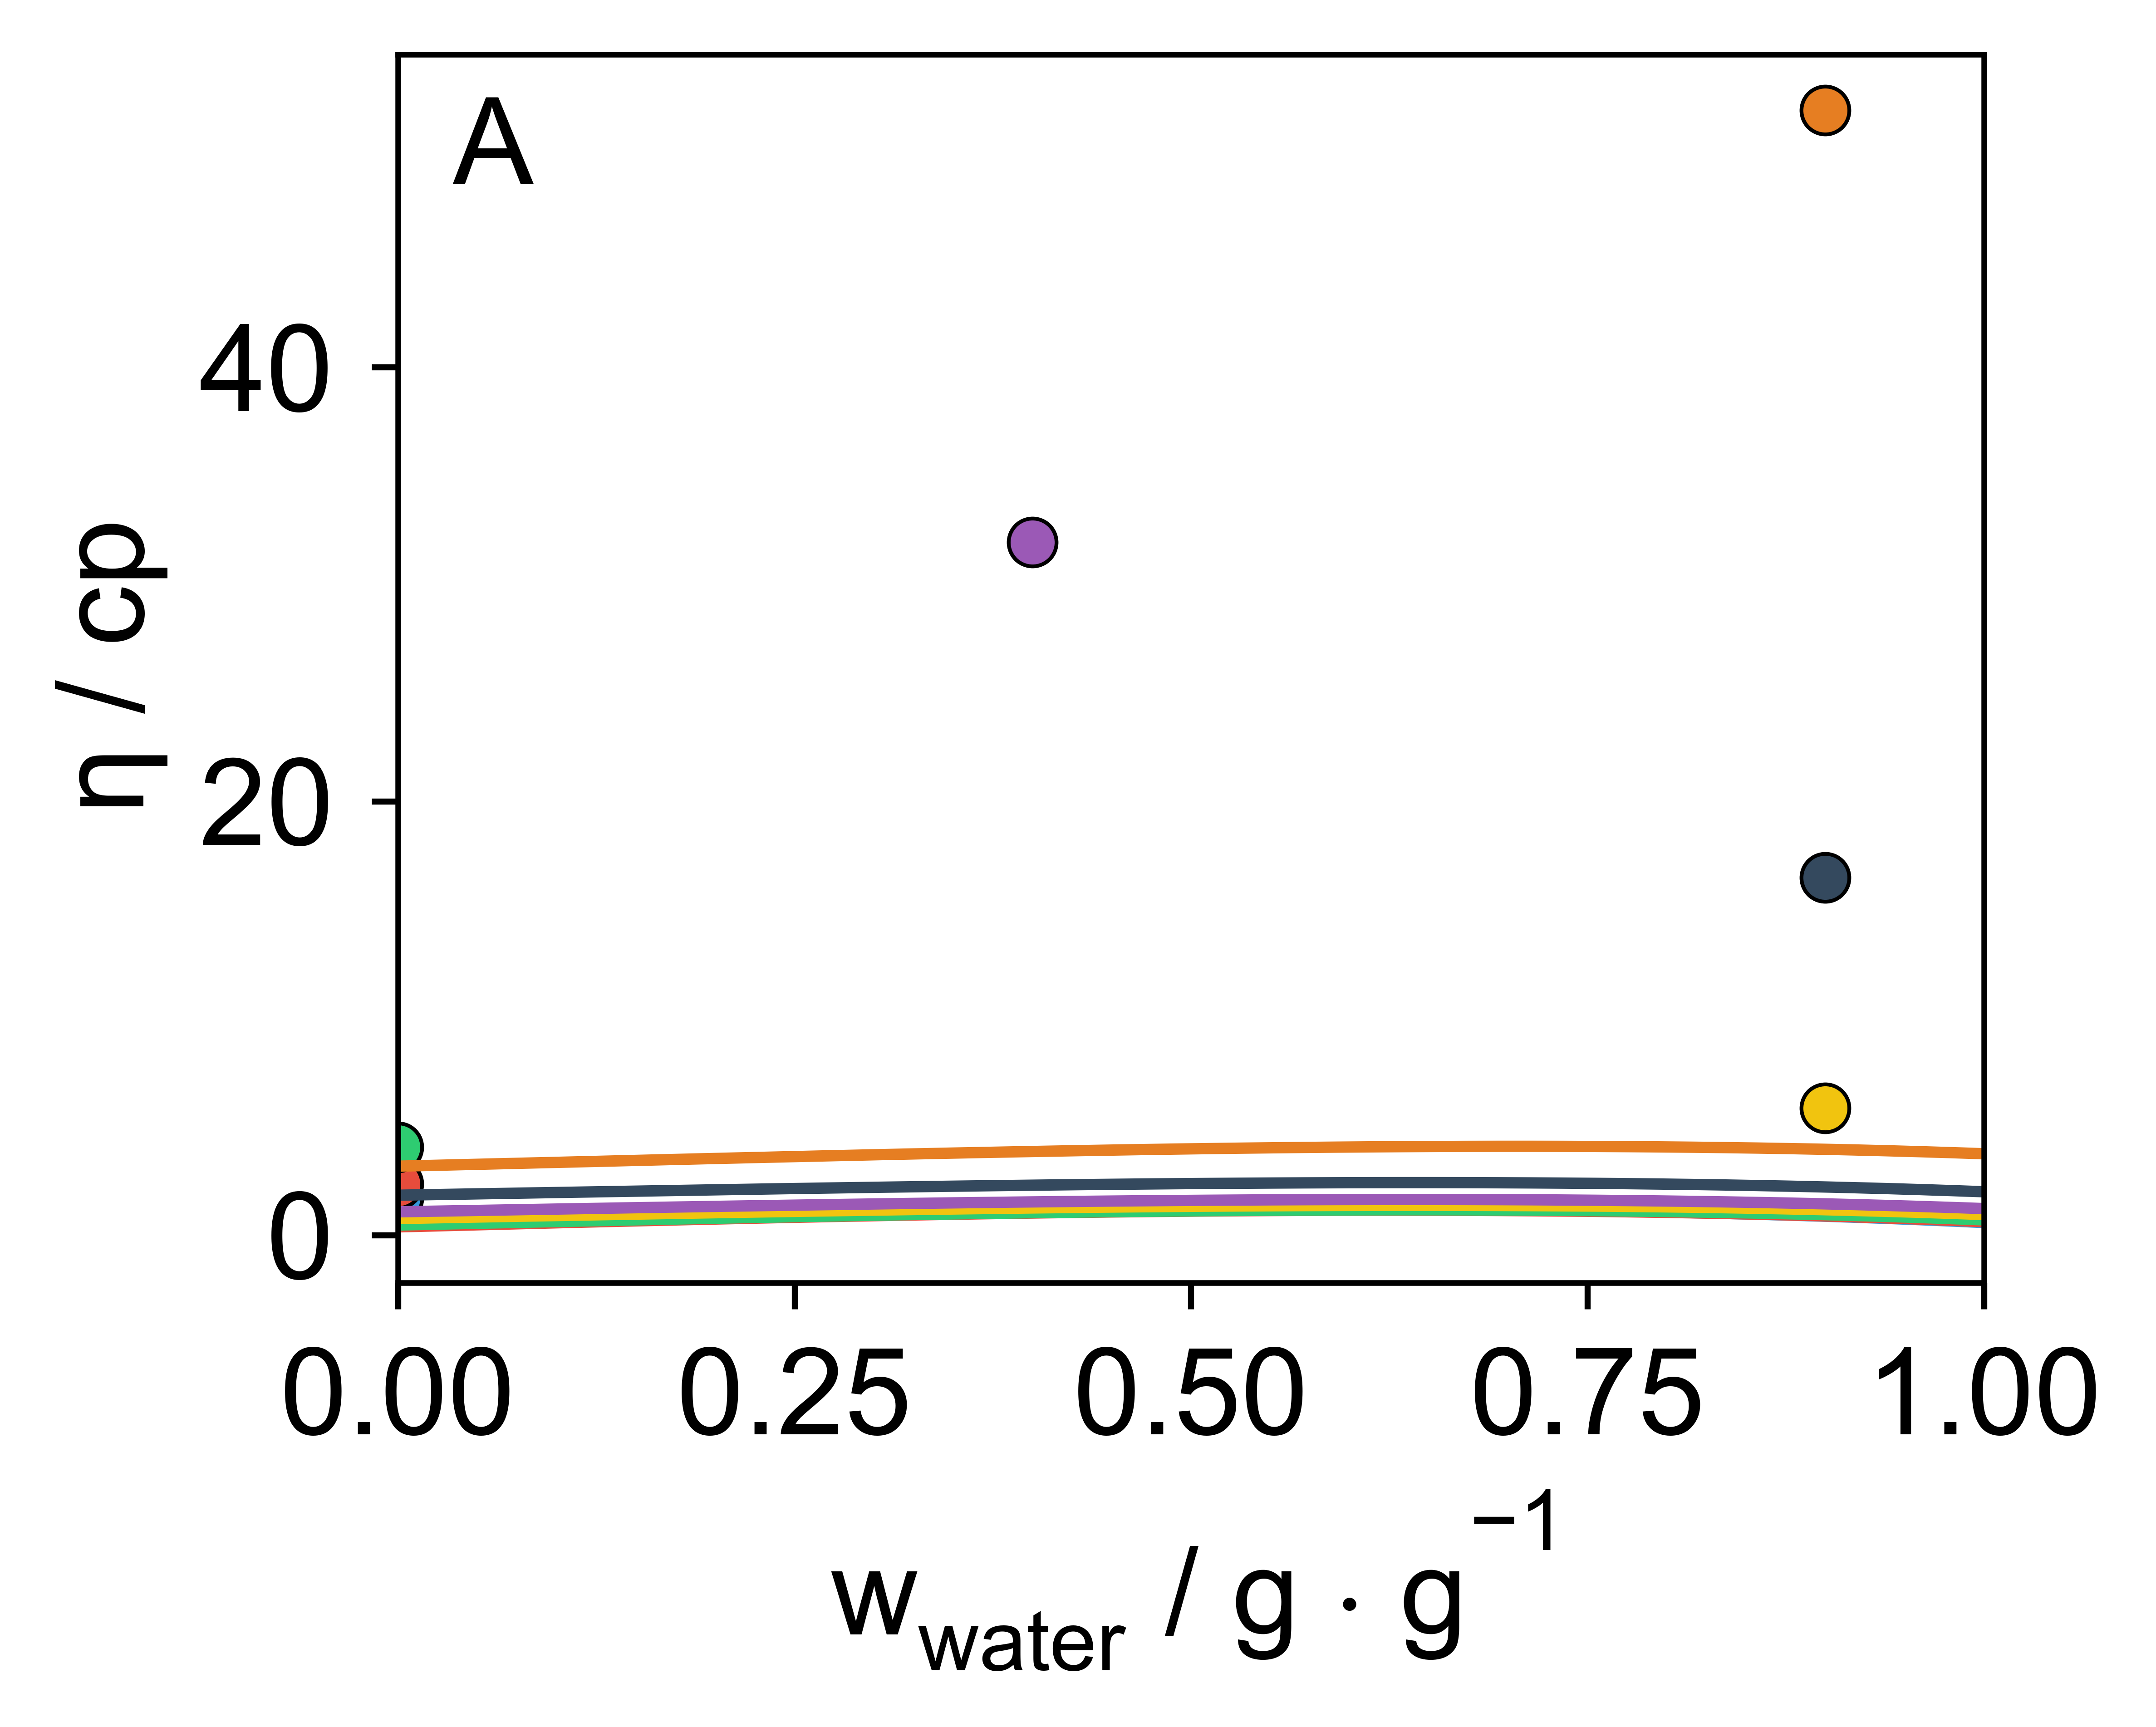

In [ ]:
fig, ax = plt.subplots( figsize=(3.93701, 3.1496), dpi=1200)
ax.text(0.06, 0.92, 'A', horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize = 16) 

solvent_name = 'ethanol'
cation = 'Li+'
anion = 'Cl-'
calculation_plot(solvent_name, cation, anion, ax)
#start, end = ax.get_ylim()
#ax.set_ylim([1, 1.4])
ax.set_xlim([0, 1])
ax.set_xlabel(r'$w_{water}$ / g $\cdot$ g$^{-1}$')
ax.set_ylabel(r'$\eta$ / cp')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig('../figures/04B_viscosity_ethanol_at_298K_FVT_method_' + method + '.pdf', dpi=1200)
plt.show()